# K-means Clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from clustering_metric import mean_index_adequacy
from clustering_metric import cluster_dispersion_index
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.colors

/Users/royliao/.pyenv/versions/3.9.1/envs/eda/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
'''
import mock energy data and weather data, the data sets are already cleaned beforehand
the data are collected from year 2020
''' 

### import data sets
energy = pd.read_csv(r'data_set/Energy.csv')
energy['DateTime'] = pd.to_datetime(energy['DateTime']) 
energy = energy.set_index('DateTime')

In [3]:
### make pivot representiative daily energy profile and also make MinMax scaled dataframe for following steps
def Daily_profile(df):
    df_pivot = df.resample('H').sum()
    df_pivot['hour'] = df_pivot.index.hour
    df_pivot.index = df_pivot.index.date
    df_pivot = df_pivot.pivot(columns='hour')
    df_pivot = df_pivot.dropna()  
    scaler = MinMaxScaler()
    scaled_df = scaler.fit_transform(df_pivot.values)
    return df_pivot, scaled_df

In [4]:
### clustering indice
def Clustering_indice(scaled_df, cluster_number):
    elbow_scores_ = []
    mean_index_adequacy_= []
    cluster_dispersion_index_ = []
    cluster_list = np.arange(2,cluster_number+1).astype(int)
    # k-means prediction
    for n_cluster in cluster_list:
        kmeans = KMeans(n_clusters=n_cluster)
        cluster_found = kmeans.fit_predict(scaled_df)
        elbow_scores_.append(davies_bouldin_score(scaled_df, kmeans.labels_))
        mean_index_adequacy_.append(mean_index_adequacy(scaled_df, kmeans.labels_))
        cluster_dispersion_index_.append(cluster_dispersion_index(scaled_df, kmeans.labels_))
    #plot the indice values
    y1 = elbow_scores_
    y2 = mean_index_adequacy_
    y3 = cluster_dispersion_index_
    x =  cluster_list
    line1, = plt.plot(x , y1) # DBI
    line2, = plt.plot(x , y2) # MIA
    line3, = plt.plot(x , y3) # CDI
    plt.xlabel('Number of Clusters')
    plt.xticks(np.arange(2,cluster_number+1))
    plt.ylabel('Index Value')
    plt.title('Clustering Index Metrics')
    plt.legend([line1, line2, line3], [ 'DBI', 'MIA', 'CDI'])
    plt.savefig(r'figure/clustering_indice.pdf', format='pdf', bbox_inches='tight')

In [5]:
#clustering 
def Kmeans_clustering(df_pivot, scaled_df, k):
    if k == 1:
        return print('At least 2 clusters.')
    elif k > 6:
        return print('Too many clusters.')
    
    #k-means clustering learning
    kmeans = KMeans(n_clusters= k)
    cluster_found = kmeans.fit_predict(scaled_df)
    cluster_found_sr = pd.Series(cluster_found, name='cluster') # make array of founded clusters values 
    cluster_plot = df_pivot.set_index(cluster_found_sr, append=True)
    
    # plot clustering results
    colors = ["royalblue", "darkorange", "forestgreen", "mediumvioletred", "gold", "cyan"] #set colors for different clusters
    fig, ax= plt.subplots(1,1, figsize=(12,6))
    cluster_values = sorted(cluster_plot.index.get_level_values('cluster').unique())
    for cluster, color in zip(cluster_values, colors):
        cluster_plot.xs(cluster, level=1).T.plot(ax=ax, legend= False, alpha=0.02, color=color)
        cluster_plot.xs(cluster, level=1).median().plot(ax=ax, color=color, alpha=0.9, ls='--', legend= False)

    blue_patch = mpatches.Patch(color='royalblue' , label='Cluster 1')
    orange_patch = mpatches.Patch(color='darkorange' , label='Cluster 2')
    green_patch = mpatches.Patch(color='forestgreen' , label='Cluster 3')
    red_patch = mpatches.Patch(color='mediumvioletred', label='Cluster 4')
    gold_patch = mpatches.Patch(color='gold', label='Cluster 5')
    cyan_patch = mpatches.Patch(color='cyan', label='Cluster 6')
    if k == 2:
        ax.legend(handles=[blue_patch, orange_patch])
    elif k == 3:
        ax.legend(handles=[blue_patch, orange_patch, green_patch])
    elif k == 4:
        ax.legend(handles=[blue_patch, orange_patch, green_patch, red_patch])
    elif k == 5:
        ax.legend(handles=[blue_patch, orange_patch, green_patch, red_patch, gold_patch])
    elif k == 6:
        ax.legend(handles=[blue_patch, orange_patch, green_patch, red_patch, gold_patch, cyan_patch])
        
    ax.set_xticks(np.arange(0,24))
    ax.set_xticklabels(np.arange(1,25))
    ax.set_xlim(0,23)
    ax.set_ylabel('Energy (kWh)')
    ax.set_xlabel('Hour of day')
    plt.title('Clustered Daily Energy Load Profiles')
    plt.show()
    fig.savefig(r'figure/clustering.pdf', format='pdf', bbox_inches='tight')
    return kmeans

In [6]:
### t-SNE validation with clustering results
def TSNE_validation(scaled_df, kmeans_cluster):
    tsne = TSNE()
    results_tsne = tsne.fit_transform(scaled_df)
    group = kmeans_cluster.labels_
    #plot the t-SNE results
    cdict = {0:"royalblue", 1:"darkorange", 2:"forestgreen", 3:"mediumvioletred", 4:"gold", 5:"cyan"}
    fig, ax = plt.subplots()
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(results_tsne[:,0][ix], results_tsne[:,1][ix], c = cdict[g], alpha=0.6, label = 'Cluster '+str(g+1))
    ax.legend()
    plt.title('Result of t-SNE')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()
    fig.savefig(r'figure/clustering_tsne.pdf', format='pdf', bbox_inches='tight')

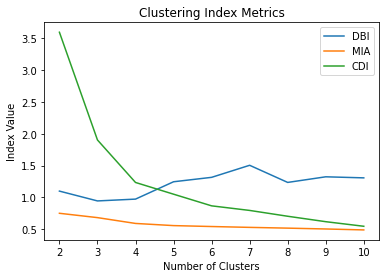

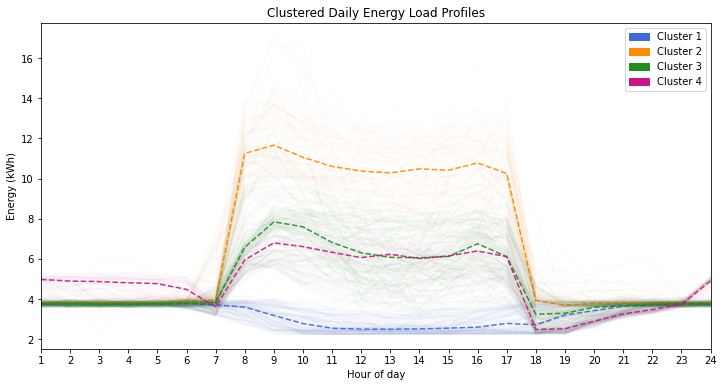

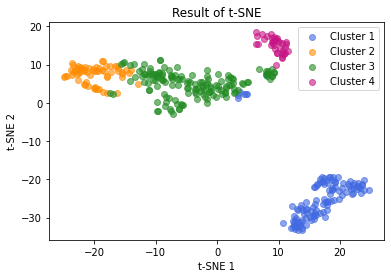

In [8]:
### make pivot representiative daily energy profile
energy_pivot,scaled_energy = Daily_profile(energy)
### calculte clustering indice values
cluster_number = 10
Clustering_indice(scaled_energy,cluster_number)
### Kmeans clustering results
number_of_cluster = 4
kmeans_cluster = Kmeans_clustering(energy_pivot,scaled_energy,number_of_cluster)
### t-SNE validation
TSNE_validation(scaled_energy, kmeans_cluster)